In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
def auto_canny(image, sigma=0.33):
    
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    
    # return the edged image
    return edged

In [7]:
from scipy.spatial import distance as dist
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [3]:
def four_point_transform(image, pts):
    
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
  
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped
    
    #return (tl[0], tl[1], maxWidth, maxHeight)

(500, 666, 3)


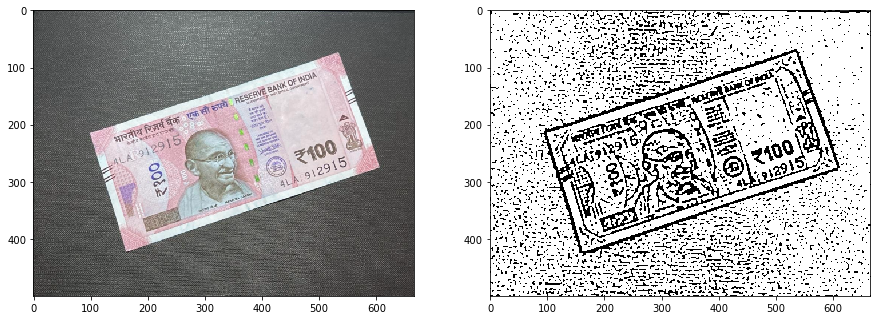

In [16]:
import imutils
image = cv2.imread('train_image/3/16.jpg')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)


# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
"""edged = auto_canny(gray)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)"""
thresh2=cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
thresh2 = cv2.erode(thresh2, None, iterations=1)
thresh2 = cv2.dilate(thresh2, None, iterations=1)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(thresh2,cmap='gray')
print(image.shape)

STEP 2: Find contours of paper


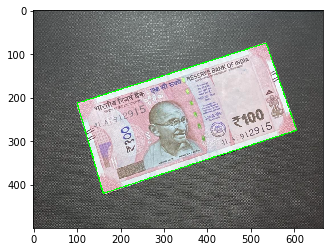

In [12]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
flag=0
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        flag=1
        break

    # show the contour (outline) of the piece of paper
if flag!=0:
    print("STEP 2: Find contours of paper")
    im=cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    plt.imshow(im)

STEP 3: Apply perspective transform
(500, 500, 3)


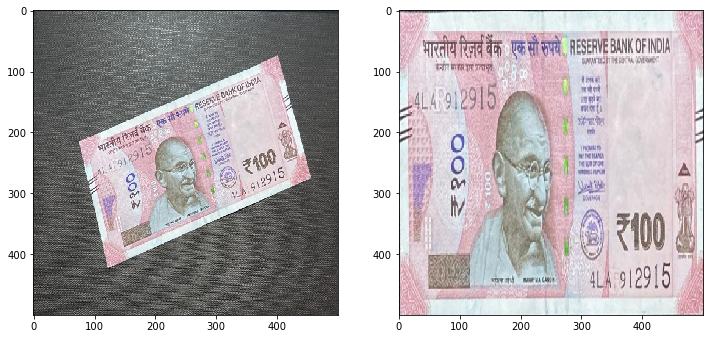

In [13]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
#warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
#T = threshold_local(warped, 11, offset = 10, method = "gaussian")
#warped = (warped > T).astype("uint8") * 255


# show the original and scanned images
print("STEP 3: Apply perspective transform")
#orig=imutils.resize(orig, height = 650)
#warped=imutils.resize(warped, height = 650)
orig=cv2.resize(orig, (500, 500),interpolation = cv2.INTER_NEAREST) 
warped=cv2.resize(warped, (500, 500),interpolation = cv2.INTER_NEAREST) 

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.subplot(1,2,2)
plt.imshow(warped)
print(warped.shape)

In [23]:
def orb_with_flann(image_query, image_train):
    
    orb = cv2.ORB_create(nfeatures=3000)

    # find key point and descriptor
    kp_logo, des_logo = orb.detectAndCompute(image_train, None)
    kp_img, des_img = orb.detectAndCompute(image_query, None)

    # view key point
    #result_image_train = cv2.drawKeypoints(image_train, kp_logo, None, flags=0)
    #result_image_query = cv2.drawKeypoints(image_query, kp_img, None, flags=0)
    #display_image(result_image_train,"train")
    #display_image(result_image_query,"query")

    # FLANN parameters
    flann_index_lsh = 6
    index_params = dict(algorithm=flann_index_lsh,
                        table_number=12,
                        key_size=20,
                        multi_probe_level=2)
    search_params = dict(checks=50)  # or pass empty dictionary

    # create FLANN
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # perform matching
    flann_matches = flann.knnMatch(des_logo, des_img, k=2)

    #View match without fillter.
    #img3 = cv2.drawMatchesKnn(image_train, kp_logo, image_query, kp_img, flann_matches, None)
    #display_image(img3)
    #plt.imshow(img3)
    # Need to draw only good matches, so create a mask
    matches_mask = [[0, 0] for i in range(len(flann_matches))]

    # ratio test as per Lowe's paper
    good = []
    for index in range(len(flann_matches)):
        if len(flann_matches[index]) == 2:
            m, n = flann_matches[index]
            if m.distance < 0.8 * n.distance:  # threshold of ratio testing
                matches_mask[index] = [1, 0]
                good.append(flann_matches[index])

    # draw match after filter
    draw_params = dict(
        singlePointColor=(255, 0, 0),
        matchesMask=matches_mask,
        flags=2)

    img3 = cv2.drawMatchesKnn(image_train, kp_logo, image_query, kp_img, flann_matches, None, **draw_params)

    #font = cv2.FONT_HERSHEY_SIMPLEX
     #cv2.putText(img3, str(len(good)), (0, 50), font, 2, (0, 0, 255), 2, cv2.LINE_AA)
    #display_image(img3)  # view matching image
    plt.figure(figsize = (10,10))
    plt.imshow(img3)
    
    #return image_train, len(good)

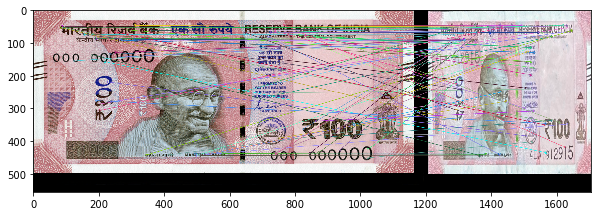

In [24]:
image_train = cv2.imread('official dataset/3/100.png')
image_query = warped.copy()

orb_with_flann(image_query, image_train)


In [9]:
des=[]
des.append(des_logo)
#des_logo.dtype
descr=des_logo
#descr.dtype

In [10]:
from skimage.util import img_as_float
desc=img_as_float(descr)


In [11]:
d=desc.flatten()

In [12]:
d.shape

(88480,)

In [13]:
d[3]

0.8588235294117647

# HOG FEATURES

In [26]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

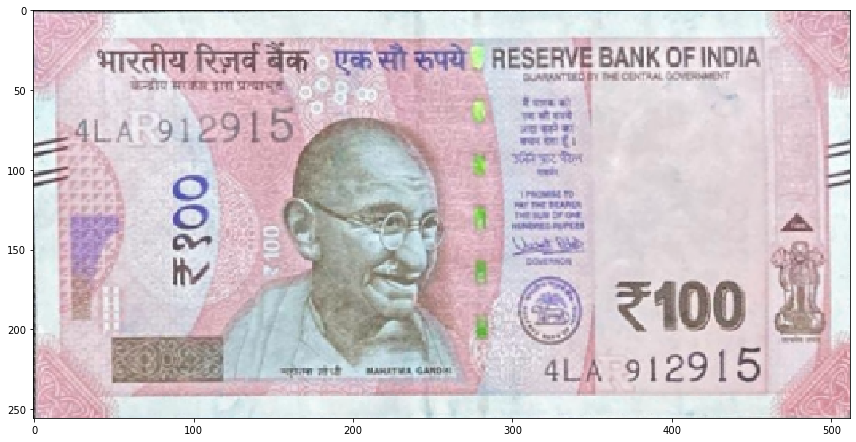

In [27]:
resized=[]
plt.figure(figsize=(12,12))
#for i in range(len(imCr2)):
resized_img = resize(warped, (256,512)) 
imshow(resized_img)
resized.append(resized_img)

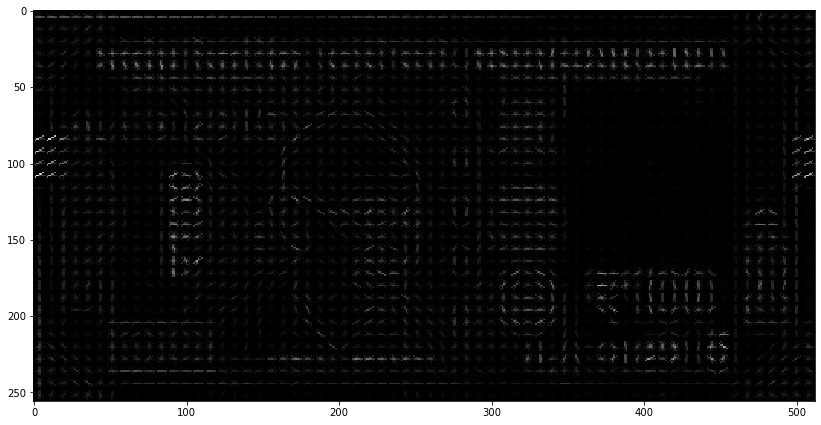

In [30]:
D=[]
HOG=[]
#for i in range(len(resized)):
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 
#FD.append(fd)
HOG.append(hog_image_rescaled)
plt.figure(figsize=(14,14))
plt.imshow(HOG[0],cmap='gray')




In [17]:
fd.shape

(70308,)

In [18]:
fd.dtype

dtype('float64')

In [19]:
fd[9]

0.23385914351003703

In [20]:
F=np.hstack([d,fd])
F.shape

(158788,)

In [41]:
Feature=[]
Feature.append(F)
Feature=np.array(Feature)
Feature.shape

(1, 157828)

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
F=scaler.fit_transform(Feature)
F[1][4]

IndexError: index 1 is out of bounds for axis 0 with size 1

# TEMPLATE MATCHING

In [8]:
template = cv2.imread('template.jpeg')

In [11]:
# loop over the images to find the template in
# load the image, convert it to grayscale, and initialize the
# bookkeeping variable to keep track of the matched region
#image=cv2.imread('our_dataset/test/200_1.jpeg')
def template_match(image,template):
    (tH, tW) = template.shape[:2]
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    found = None
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])

        if resized.shape[0] < tH or resized.shape[1] < tW:
            break

        edged = cv2.Canny(resized, 50, 200)
        result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
        (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

        clone = np.dstack([edged, edged, edged])
        cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),
        (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
        #plt.imshow(clone)
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)

    (_, maxLoc, r) = found
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
    
    r=[startX,startY,endX,endY]
    #cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    #plt.imshow(image)
    return r

In [12]:
r=template_match(image,template)
Crop= image[int(r[1]):int(r[3]), int(r[0]):int(r[2])]
plt.imshow(Crop)


error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\imgproc\src\templmatch.cpp:1102: error: (-215:Assertion failed) (depth == 0 || depth == 5) && type == _templ.type() && _img.dims() <= 2 in function 'cv::matchTemplate'


# Global Feature extraction

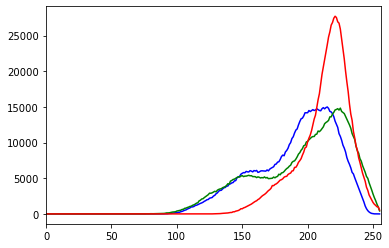

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = warped
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


In [21]:
bins=8
def fd_histogram(img, mask=None):
    
    # convert the image to HSV color-space
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # compute the color histogram
    hist = cv2.calcHist([image], [0, 1,2], None, [bins, bins,bins], [0, 256, 0, 256, 0 ,256])
    
    #normalize the histogram
    cv2.normalize(hist, hist)
    
    #print(hist.flatten())
    # return the histogram
    return hist.flatten()

In [24]:
features=fd_histogram(warped)
features.shape

(512,)

In [87]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [88]:
 # Global Feature extraction
        ####################################
        global_features=[]
        fv_hu_moments = fd_hu_moments(warped)
        fv_histogram  = fd_histogram(warped)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_hu_moments])
        global_features.append(global_feature)

In [89]:
global_features

[array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.13987772e-24,  2.42944847e-15, -1.33752806e-24])]

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
rescaled_features

array([[0., 0., 0., ..., 0., 0., 0.]])

# Rotating Bounding box

In [46]:
image = cv2.imread("2000_1.jpeg")
ratio = image.shape[0] /500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

Object #1:
[[ 12 406]
 [ 12 153]
 [644 153]
 [644 406]]


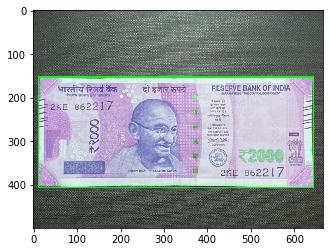

In [47]:
from imutils import contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the bounding box
# point colors

(cnts, _) = contours.sort_contours(cnts)
colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))
for (i, c) in enumerate(cnts):
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue
	# compute the rotated bounding box of the contour, then
	# draw the contours
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")
	image2=cv2.drawContours(image, [box], -1, (0, 255, 0), 2)
	# show the original coordinates
	print("Object #{}:".format(i + 1))
	print(box)
plt.imshow(image2)